# Comparisons of High-Order Explicit Corrections or Sources

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import fluidfoam as foam
from initialConditions import *
from expCorrSchemes import *
#from fluxLimiters.fluxLimiters import *
matplotlib.rcParams['figure.dpi'] = 600
matplotlib.rcParams['figure.figsize'] =(8, 6)

In [2]:
# Function for schemes comparisions

def compareSchemes(params, fluxes, options, labels, OFcases = [], OFtimes=[], OFfields=[],
                    OFlabels = []):
    """Solve the advection equation for various schemes and plot the results
    params: dict with entries "nt", "nx", "c", "initialConditions", "title", "fileName"
    fluxes: List of flux functions
    options: List of dictionaries to send to the flux functions
    labels:  Labels for the legend of the graph for each flux function
    """
    dt = params["c"]/params["nx"]
    dx = 1/params["nx"]
    print('Solving the advection equation for', dt*params["nt"],
          'revolutions of a periodic domain with spatial resolution', dx)
    x = np.arange(0,1, dx)
    phi0 = params["initialConditions"](x)
    phiE = params["initialConditions"]((x-dt*params["nt"])%1)
    #fig,ax = plt.subplots(1,2, figsize=(12,4), layout='constrained')
    #fig.sup
    plt.title(params["title"]+'\nc = '+str(round(params["c"],2))+' nx = '
              +str(params["nx"]) + ' nt = '+str(params["nt"]))
    plt.plot(x, phi0, 'k--', label = 't=0')
    plt.plot(x, phiE, 'k', label='t='+str(round(dt*params["nt"],2)))
    plt.axhline(y=0, color='k', ls=':', lw=0.5)
    plt.axhline(y=0.5, color='k', ls=':', lw=0.5)

    # Run all the schemes and plot the results
    lines = ['k-o', 'r--', 'b-x', 'g--+', 'c--', 'm:', 'k:', 'r:', 'b:', 'c:', 'g:']
    for flux, name, option, line in zip(fluxes, labels, options, lines):
        phi = phi0.copy()
        for it in range(params["nt"]):
            phi = advectImplicitExpCorr(phi, params["c"], flux, option["nCorr"],
                                        split=option["split"], options=option)
        plt.plot(x, phi, line, label=name)
        #ax[1].plot(x, phi - phiE, label=name)

    # Add the OpenFOAM results
    lines = lines[len(fluxes):-1]
    for case, time, field, label, line in zip(OFcases, OFtimes,OFfields,OFlabels,lines):
        phi = foam.readscalar(case, str(time), field)
        plt.plot(x, phi, line, label=label)
    
    plt.legend()#bbox_to_anchor=(1.1, 1))
    #ax[0].set(ylabel=r'$\psi$', title = 'Totals', xlim=[0,1])
    #ax[1].set(ylabel='Error', title = 'Errors', xlim=[0,1])
    plt.xlim([0,1])
    plt.savefig(params["fileName"])
    plt.show()

# calculate the number of time steps from the number of revolutions, nx and c
nt = lambda nRevs, nx, c : int(nRevs*nx/c)


Solving the advection equation for 0.1125 revolutions of a periodic domain with spatial resolution 0.025
Reading file /home/hilary/OpenFOAM/hilary-dev/run/advection/halfWave/CN1_CD_c4p5_nCorr1_MULES2_applyPrev0_extrema0/0.1125/T


/home/hilary/python/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/hilary/python/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/hilary/python/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


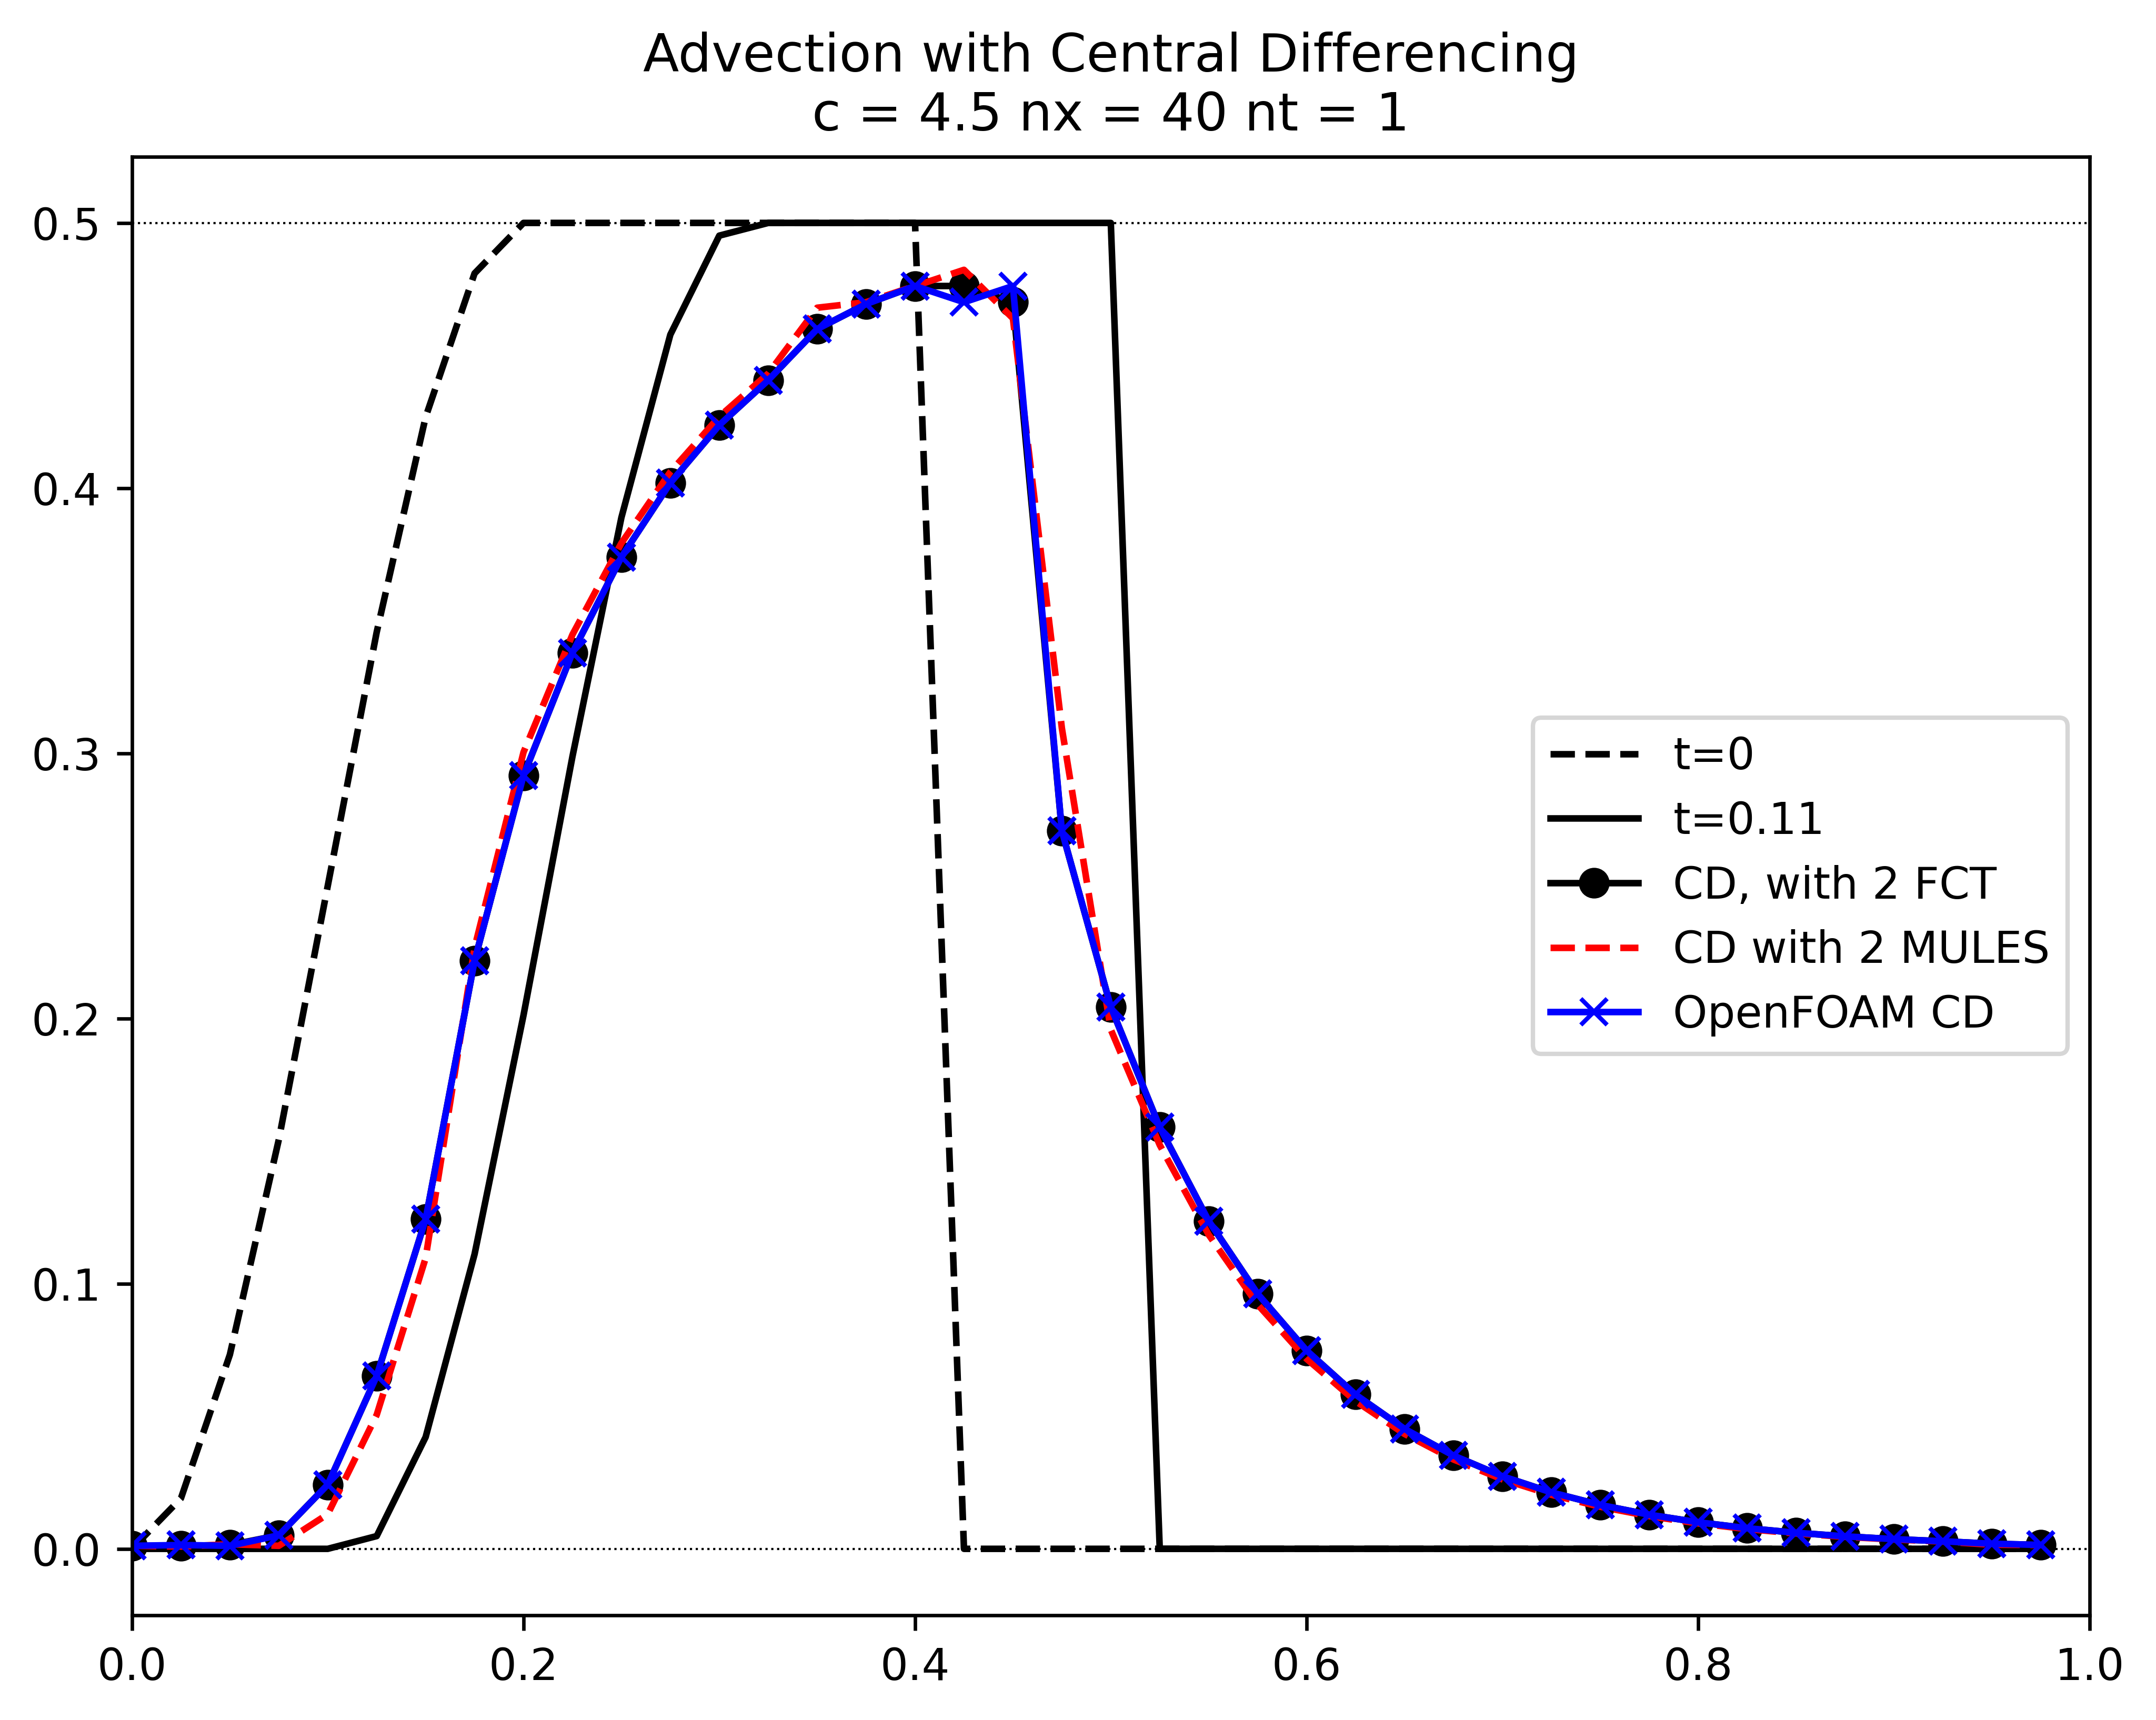

In [3]:
from expCorrSchemes import *
fluxes = 2*[CDFlux]
options = [{"split": True, "nCorr": 1, "limiter": FCT,   "limiterCorr": 2},
           {"split": True, "nCorr": 1, "limiter": MULES, "limiterCorr": 2}]#, "minT": 0, "maxT": 1}]
labels = ["CD, with 2 FCT", "CD with 2 MULES"]


compareSchemes(
    {"nt": 1, "nx":40, "c":4.5, "initialConditions":halfWave,
     "title": "Advection with Central Differencing",
     "fileName": "plots/CD_c4p5.pdf"},
    fluxes, options, labels,
    OFcases = ['/home/hilary/OpenFOAM/hilary-dev/run/advection/halfWave/CN1_CD_c4p5_nCorr1_MULES2_applyPrev0_extrema0'], 
    OFtimes=['0.1125'], OFfields=['T'], OFlabels = ['OpenFOAM CD'])

Solving the advection equation for 0.1125 revolutions of a periodic domain with spatial resolution 0.025
Reading file /home/hilary/OpenFOAM/hilary-dev/run/advection/halfWave/CN1_CD_c4p5_nCorr1_MULES2_applyPrev0_extrema0/0.1125/T
Reading file /home/hilary/OpenFOAM/hilary-dev/run/advection/halfWave/CN044_CD_c4p5_nCorr1_MULES2_applyPrev0_extrema0/0.1125/T
Reading file /home/hilary/OpenFOAM/hilary-dev/run/advection/halfWave/CN1_CD_c4p5_nCorr1_MULES2_applyPrev1_extrema0/0.1125/T


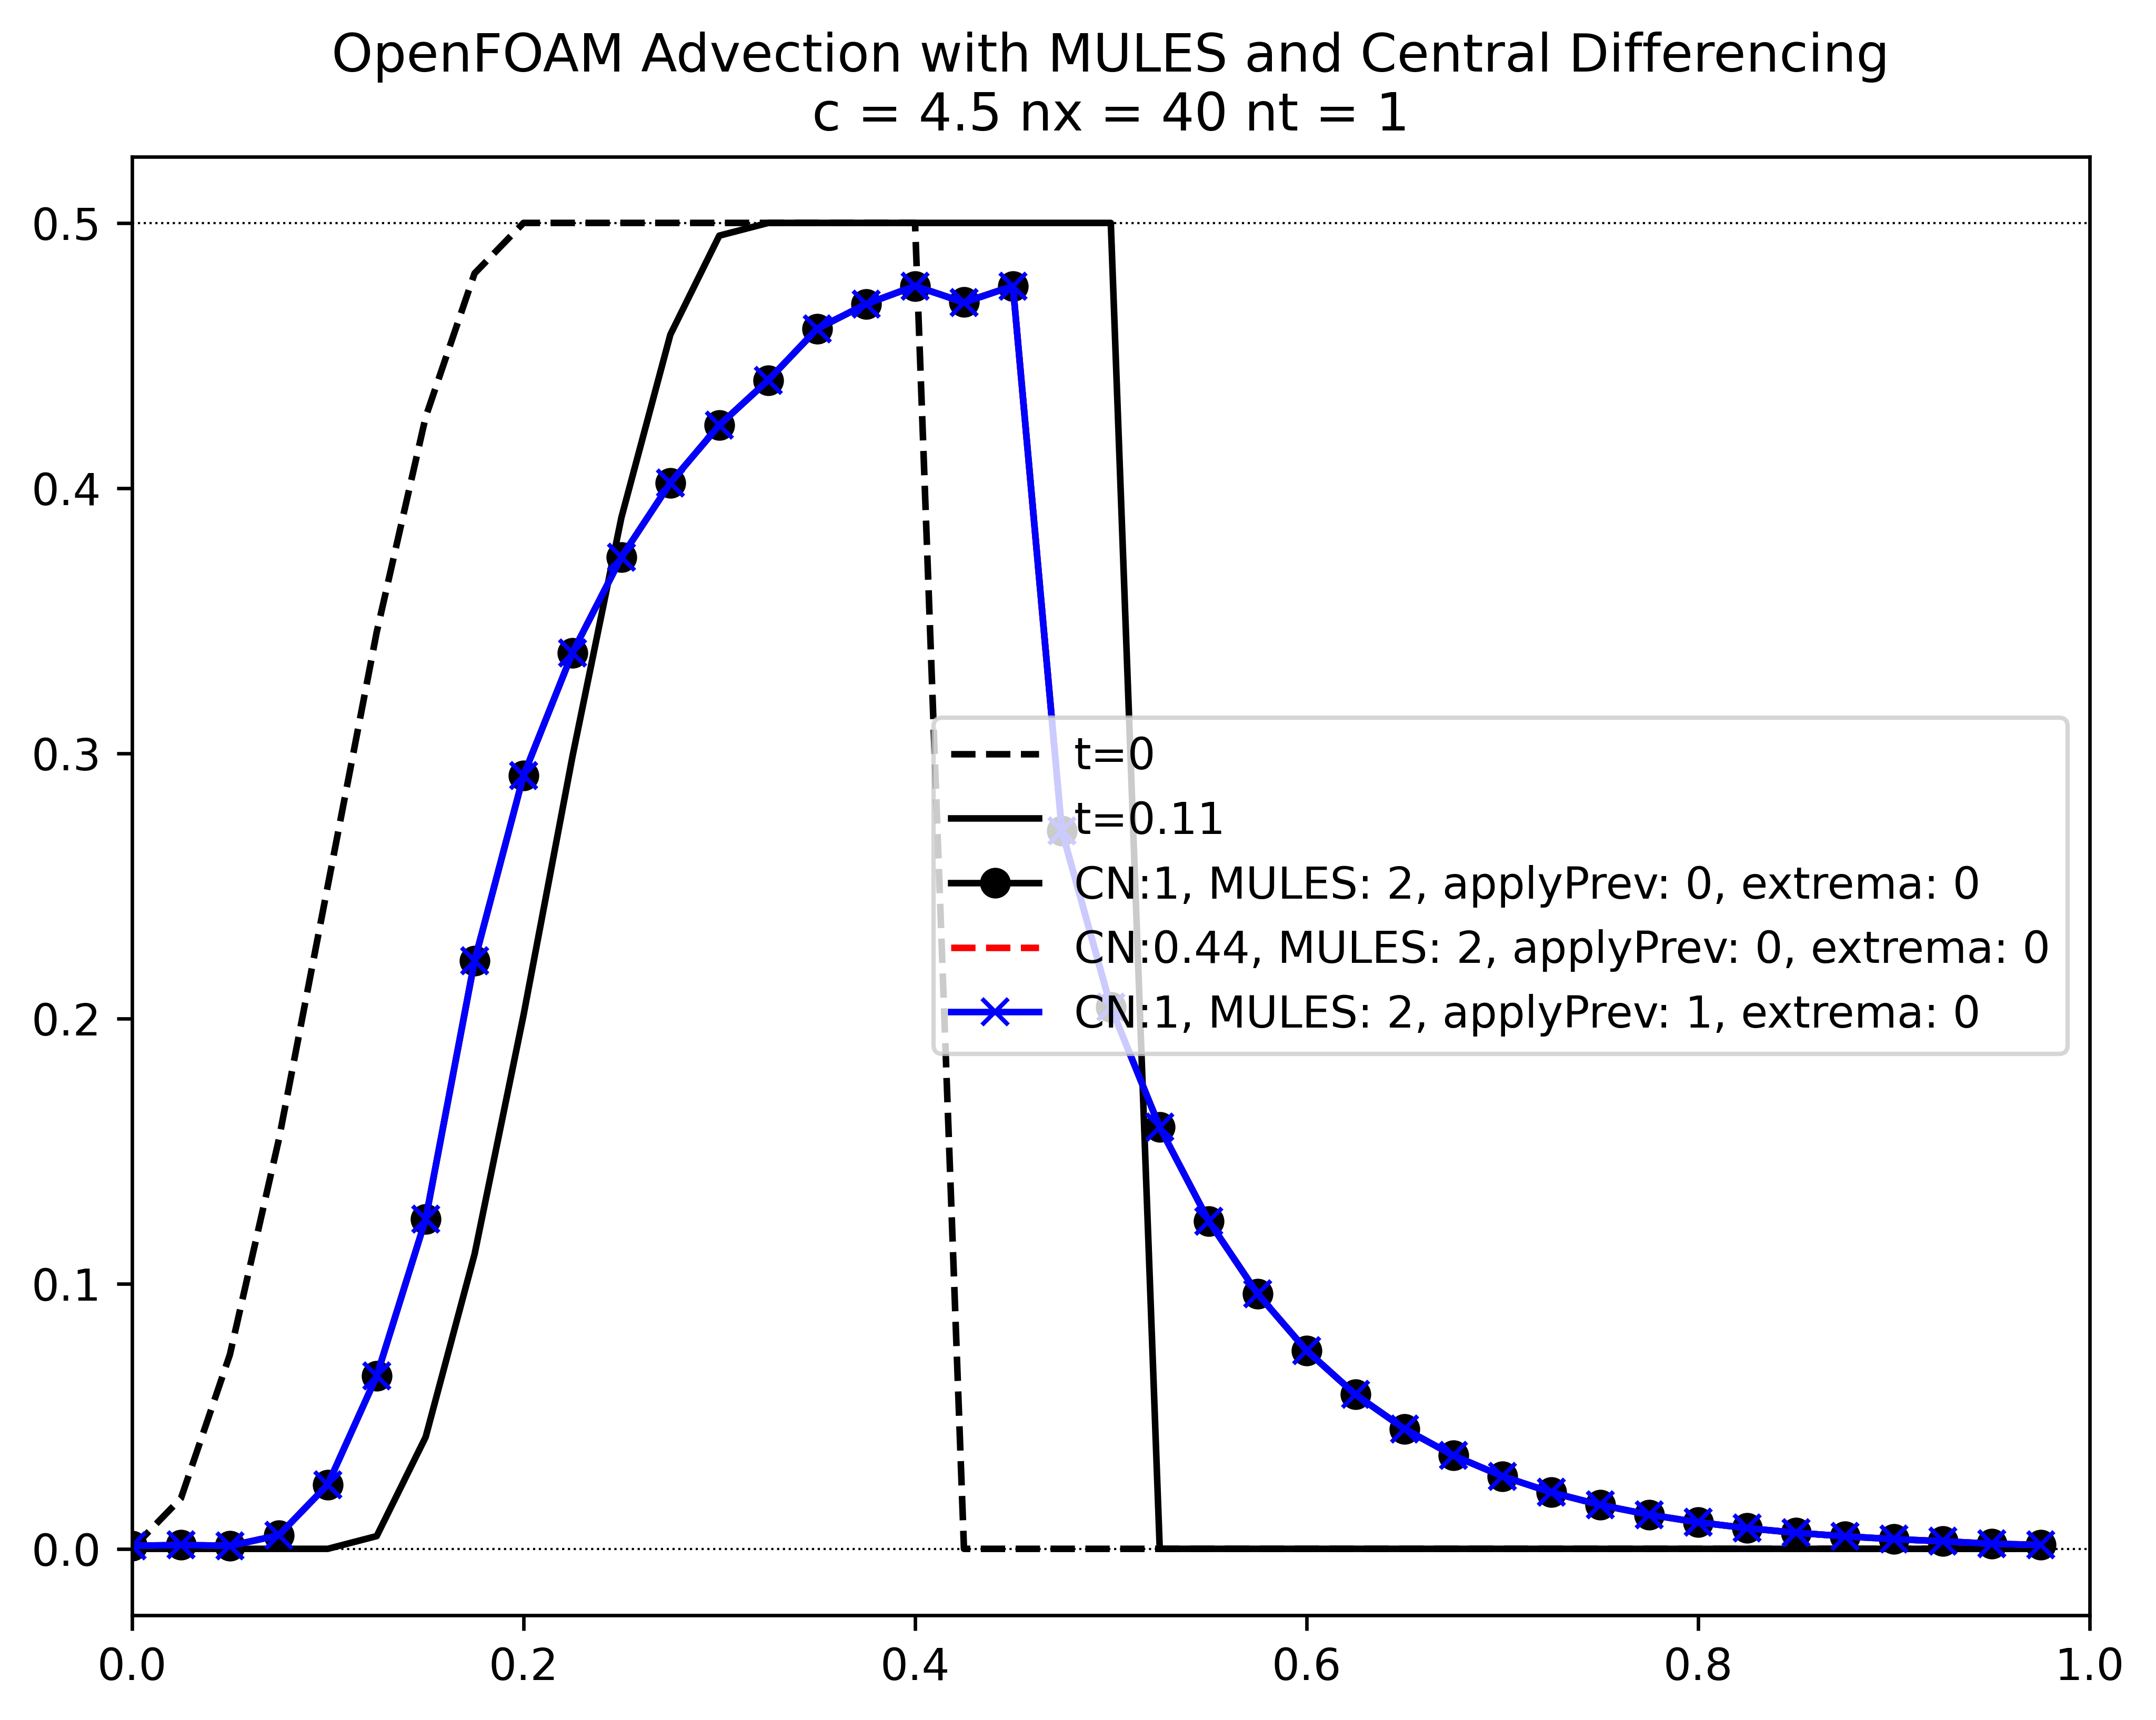

In [5]:
# Compare OpenFOAM results
fluxes = []
options = []
labels = []
OFroot = '/home/hilary/OpenFOAM/hilary-dev/run/advection/halfWave/'

compareSchemes(
    {"nt": 1, "nx":40, "c":4.5, "initialConditions":halfWave,
     "title": "OpenFOAM Advection with MULES and Central Differencing",
     "fileName": "plots/OpenFOAM_MULES_c4p5.pdf"},
    fluxes, options, labels,
    OFcases = [OFroot+'CN1_CD_c4p5_nCorr1_MULES2_applyPrev0_extrema0',
               OFroot+'CN044_CD_c4p5_nCorr1_MULES2_applyPrev0_extrema0',
               OFroot+'CN1_CD_c4p5_nCorr1_MULES2_applyPrev1_extrema0'], 
    OFtimes=3*['0.1125'], OFfields=3*['T'], 
    OFlabels = ['CN:1, MULES: 2, applyPrev: 0, extrema: 0',
                'CN:0.44, MULES: 2, applyPrev: 0, extrema: 0',
                'CN:1, MULES: 2, applyPrev: 1, extrema: 0'])

## Stability Analysis of the Split Explicit Correction (OpenFOAM) Scheme
The unlimited scheme used in OpenFOAM for MULES uses a high-order correction on first-order upwind. Consider the solution of the one-dimensional linear advection equation for $T$, with uniform Courant number, $c>0$, grid points indexed by $j$ and time levels $n$. The first step is to find a bounded solution, $T^{1}$, using upwind spatial discretisation and off-centred trapezoidal-implicit time stepping:
\begin{equation}
T^1_j = T^{(n)}_j - (1-\alpha_L)c\left(T^{n}_j - T^{n}_{j-1}\right) - \alpha_L c\left(T^1_j - T^1_{j-1}\right)
\end{equation}
where $\alpha_L$ is the temporal off centering for the bounded, low-order solution:
\begin{equation}
\alpha_L = 1 - 1/\max(c,2)
\end{equation}
Next we apply high order iterations indexed by $\ell$ starting from $T^{\ell=1}=T^1$:
\begin{equation}
T^{\ell+1}_j = T_j^{(n)} - (1-\alpha_H) c \left(T_{j+1/2}^{(n)} - T_{j-1/2}^{(n)}\right)
                         - \alpha_H c \left(T_{j+1/2}^{\ell} - T_{j-1/2}^{\ell}\right)
\end{equation}
where $\alpha_H$ is the off-centering for the high-order solution and $T_{j+1/2}$ are the high-order reconstructions at the interfaces. For the simplest analysis we use:
\begin{equation}
T_{j+1/2} = \frac{1}{2}\left(T_j + T_{j+1}\right)
\end{equation}
For $\ell>2$, under-relaxation is needed for stability:
\begin{eqnarray}
T_j^{\ell+1} &=& (1-\theta)T_j^{\ell} + \theta\left(
    T_j^{(n)} - (1-\alpha_H) c \left(T_{j+1/2}^{(n)} - T_{j-1/2}^{(n)}\right)
                         - \alpha_H c \left(T_{j+1/2}^{\ell} - T_{j-1/2}^{\ell}\right)
\right)
\end{eqnarray}

### Von-Neumman Stability Analysis
Assume
\begin{eqnarray}
T_j^{(n)} &=& A^n e^{ikj\Delta x}\\
T_j^{\ell} &=& A^\ell T_j^{(n)}\\
\text{where} &k& \text{is a wavenumber}\\
\implies A^1 &=& 1 - (1-\alpha_L)c\left(1 - e^{-ik\Delta x}\right)
                           - \alpha_L c A^1\left(1 - e^{-ik\Delta x}\right)\\
\implies A^1 &=& \frac{1 - (1-\alpha_L)c\left(1 - e^{-ik\Delta x}\right)}
                      {1 + \alpha_L c \left(1 - e^{-ik\Delta x}\right)}\\
A^2 &=& 1 - (1-\alpha_H)\frac{c}{2}\left(e^{ik\Delta x} - e^{-ik\Delta x}\right)
                           - \alpha_H \frac{c}{2} A^1\left(e^{ik\Delta x} - e^{-ik\Delta x}\right)\\
A^{\ell+1} &=& (1-\theta)A^{\ell} + \theta\left(
1 - (1-\alpha_H) \frac{c}{2} \left(e^{ik\Delta x} - e^{-ik\Delta x} \right)
          - \alpha_H A^\ell \frac{c}{2} \left(e^{ik\Delta x} - e^{-ik\Delta x}\right)\right)
\end{eqnarray}

Grid-scale waves are not seen by the centered differences so we will consider $A$ for $k\Delta x=\pi/2\implies e^{\pm ik\Delta x}=\pm i$. Then:
\begin{eqnarray}
A^1 &=& \frac{1 - (1-\alpha_L)c(1+i)}{1 + \alpha_L c (1+i) }\\
A^2 &=& 1 - (1-\alpha_H)\frac{c}{2}(1+i)- i\alpha_H c A^1\\
A^{\ell+1} &=& (1-\theta)A^{\ell} + \theta\left(
1 - i(1-\alpha_H) c - i\alpha_H A^\ell c \right)
\end{eqnarray}

In [ ]:
# Amplification factors for alpha_H = 1 - 1/c

from numpy import exp, pi
def A1(a, c, kdx):
    return (1 - (1-a)*c*(1-exp(-1j*kdx)))/(1 + a*c*(1 - exp(-1j*kdx)))

def A2(a, c, kdx, A1):
    return 1 - (1-a)*0.5*c*(exp(1j*kdx) - exp(-1j*kdx)) - a*0.5*c*A1*(exp(1j*kdx) - exp(-1j*kdx))

def Aell(th, a, c, kdx, Al):
    return (1-th)*Al + th*(1 - (1-a)*0.5*c*(exp(1j*kdx) - exp(-1j*kdx))
                              - a*0.5*c*Al*(exp(1j*kdx) - exp(-1j*kdx)))

def aL(c):
    return 1 - 1/np.maximum(c,2)

cs = np.linspace(0, 15, 51)
kdxs = np.linspace(0, pi, 31)
ths = np.linspace(0, 0.5, 10)
A1s = np.zeros([len(kdxs),len(cs)], dtype=complex)
A2s = np.zeros([len(kdxs),len(cs)], dtype=complex)
A3s = np.zeros([len(kdxs),len(cs)], dtype=complex)

th = 0.4
for ic in range(len(cs)):
    c = cs[ic]
    for ik in range(len(kdxs)):
        kdx = kdxs[ik]
        A1s[ik,ic] = A1(aL(c), c, kdx)
        A2s[ik,ic] = A2(aL(c), c, kdx, A1s[ik,ic])
        A3s[ik,ic] = Aell(th, aL(c), c, kdx, A2s[ik,ic])

plt.contourf(cs, kdxs, abs(A2s))
plt.colorbar()
plt.contour(cs, kdxs, abs(A2s), [1.00000001, 1.00000002], colors=['k', 'k'])
plt.title('A2')
plt.xlabel('c')
plt.ylabel('kdx')
plt.show()

plt.contourf(cs, kdxs, abs(A3s))
plt.colorbar()
plt.contour(cs, kdxs, abs(A3s), [1.00000001, 1.00000002], colors=['k', 'k'])
plt.title('A3')
plt.xlabel('c')
plt.ylabel('kdx')
plt.show()

# A3 an A4 for kdx = 2 for different values of theta (th)
kdx = 2
ths = np.linspace(0, 0.5, 21)
A3s = np.zeros([len(ths), len(cs)], dtype=complex)
A4s = np.zeros([len(ths), len(cs)], dtype=complex)
for ic in range(len(cs)):
    c = cs[ic]
    for ith in range(len(ths)):
        th = ths[ith]
        A3s[ith,ic] = Aell(th, aL(c), c, kdx, A2(aL(c), c, kdx, A1(aL(c), c, kdx)))
        A4s[ith,ic] = Aell(th, aL(c), c, kdx, A3s[ith,ic])

plt.contourf(cs, ths, abs(A3s))
plt.colorbar()
plt.contour(cs, ths, abs(A3s), [1.00000001, 1.00000002], colors=['k', 'k'])
plt.title('A3')
plt.xlabel('c')
plt.ylabel('theta')
plt.show()

plt.contourf(cs, ths, abs(A4s))
plt.colorbar()
plt.contour(cs, ths, abs(A4s), [1.00000001, 1.00000002], colors=['k', 'k'])
plt.title('A4')
plt.xlabel('c')
plt.ylabel('theta')
plt.show()